In [66]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR, LinearSVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, mean_absolute_error, root_mean_squared_error, r2_score
import cloudpickle
import dill
import os
import warnings

# settings
SESSION_FILE = "variables.session"
def save_session():
    dill.dump_session(SESSION_FILE)
    print(f"Session saved to {SESSION_FILE}")
def load_session():
    if os.path.exists(SESSION_FILE):
        dill.load_session(SESSION_FILE)
        print(f"Session loaded from {SESSION_FILE}")
    else:
        print("No saved session found.")
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",None)

In [67]:
# load everything
load_session()

Session loaded from variables.session


In [68]:
# load dataset
data = pd.read_csv("retail_price.csv")
data.head()

,product_id,product_category_name,month_year,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_score,customers,weekday,weekend,holiday,month,year,s,volume,comp_1,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price
0,bed1,bed_bath_table,01-05-2017,1,45.95,15.100000,45.95,39,161,2,350,4.0,57,23,8,1,5,2017,10.267394,3800,89.9,3.9,15.011897,215.000000,4.4,8.760000,45.95,4.0,15.100000,45.90
1,bed1,bed_bath_table,01-06-2017,3,137.85,12.933333,45.95,39,161,2,350,4.0,61,22,8,1,6,2017,6.503115,3800,89.9,3.9,14.769216,209.000000,4.4,21.322000,45.95,4.0,12.933333,45.95
2,bed1,bed_bath_table,01-07-2017,6,275.70,14.840000,45.95,39,161,2,350,4.0,123,21,10,1,7,2017,12.071651,3800,89.9,3.9,13.993833,205.000000,4.4,22.195932,45.95,4.0,14.840000,45.95
3,bed1,bed_bath_table,01-08-2017,4,183.80,14.287500,45.95,39,161,2,350,4.0,90,23,8,1,8,2017,9.293873,3800,89.9,3.9,14.656757,199.509804,4.4,19.412885,45.95,4.0,14.287500,45.95
4,bed1,bed_bath_table,01-09-2017,2,91.90,15.100000,45.95,39,161,2,350,4.0,54,21,9,1,9,2017,5.555556,3800,89.9,3.9,18.776522,163.398710,4.4,24.324687,45.95,4.0,15.100000,45.95


In [69]:
# data backup
df = data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  676 non-null    object 
 1   product_category_name       676 non-null    object 
 2   month_year                  676 non-null    object 
 3   qty                         676 non-null    int64  
 4   total_price                 676 non-null    float64
 5   freight_price               676 non-null    float64
 6   unit_price                  676 non-null    float64
 7   product_name_lenght         676 non-null    int64  
 8   product_description_lenght  676 non-null    int64  
 9   product_photos_qty          676 non-null    int64  
 10  product_weight_g            676 non-null    int64  
 11  product_score               676 non-null    float64
 12  customers                   676 non-null    int64  
 13  weekday                     676 non

In [70]:
# change name of s to sales rate
df.rename(columns= {"s" : "sales_rate"}, inplace= True)
df.head()

,product_id,product_category_name,month_year,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_score,customers,weekday,weekend,holiday,month,year,sales_rate,volume,comp_1,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price
0,bed1,bed_bath_table,01-05-2017,1,45.95,15.100000,45.95,39,161,2,350,4.0,57,23,8,1,5,2017,10.267394,3800,89.9,3.9,15.011897,215.000000,4.4,8.760000,45.95,4.0,15.100000,45.90
1,bed1,bed_bath_table,01-06-2017,3,137.85,12.933333,45.95,39,161,2,350,4.0,61,22,8,1,6,2017,6.503115,3800,89.9,3.9,14.769216,209.000000,4.4,21.322000,45.95,4.0,12.933333,45.95
2,bed1,bed_bath_table,01-07-2017,6,275.70,14.840000,45.95,39,161,2,350,4.0,123,21,10,1,7,2017,12.071651,3800,89.9,3.9,13.993833,205.000000,4.4,22.195932,45.95,4.0,14.840000,45.95
3,bed1,bed_bath_table,01-08-2017,4,183.80,14.287500,45.95,39,161,2,350,4.0,90,23,8,1,8,2017,9.293873,3800,89.9,3.9,14.656757,199.509804,4.4,19.412885,45.95,4.0,14.287500,45.95
4,bed1,bed_bath_table,01-09-2017,2,91.90,15.100000,45.95,39,161,2,350,4.0,54,21,9,1,9,2017,5.555556,3800,89.9,3.9,18.776522,163.398710,4.4,24.324687,45.95,4.0,15.100000,45.95


In [71]:
# dropping irrelevant columns
df.drop(columns= ["product_id", 'month_year', "year", 'total_price', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty'], inplace= True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   product_category_name  676 non-null    object 
 1   qty                    676 non-null    int64  
 2   freight_price          676 non-null    float64
 3   unit_price             676 non-null    float64
 4   product_weight_g       676 non-null    int64  
 5   product_score          676 non-null    float64
 6   customers              676 non-null    int64  
 7   weekday                676 non-null    int64  
 8   weekend                676 non-null    int64  
 9   holiday                676 non-null    int64  
 10  month                  676 non-null    int64  
 11  sales_rate             676 non-null    float64
 12  volume                 676 non-null    int64  
 13  comp_1                 676 non-null    float64
 14  ps1                    676 non-null    float64
 15  fp1   

In [72]:
# duplicates
df.drop_duplicates(inplace= True)
print(f'no of rows reduced to {df.shape[0]}')

no of rows reduced to 676


In [73]:
# null values
df.isnull().sum()

product_category_name    0
qty                      0
freight_price            0
unit_price               0
product_weight_g         0
product_score            0
customers                0
weekday                  0
weekend                  0
holiday                  0
month                    0
sales_rate               0
volume                   0
comp_1                   0
ps1                      0
fp1                      0
comp_2                   0
ps2                      0
fp2                      0
comp_3                   0
ps3                      0
fp3                      0
lag_price                0
dtype: int64

In [74]:
# outliers
df.describe()

,qty,freight_price,unit_price,product_weight_g,product_score,customers,weekday,weekend,holiday,month,sales_rate,volume,comp_1,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price
count,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000
mean,14.495562,20.682270,106.496800,1847.498521,4.085503,81.028107,21.773669,8.658284,1.494083,6.192308,14.644970,10664.627219,79.452054,4.159467,18.597610,92.930079,4.123521,18.620644,84.182642,4.002071,17.965007,107.399684
std,15.443421,10.081817,76.182972,2274.808483,0.232021,62.055560,0.986104,0.705600,0.940430,3.243455,11.930276,9172.801850,47.933358,0.121652,9.406537,49.481269,0.207189,6.424174,47.745789,0.233292,5.533256,76.974657
min,1.000000,0.000000,19.900000,100.000000,3.300000,1.000000,20.000000,8.000000,0.000000,1.000000,0.484262,640.000000,19.900000,3.700000,0.095439,19.900000,3.300000,4.410000,19.900000,3.500000,7.670000,19.850000
25%,4.000000,14.761912,53.900000,348.000000,3.900000,34.000000,21.000000,8.000000,1.000000,3.000000,7.510204,3510.000000,49.910000,4.100000,13.826429,53.900000,4.100000,14.485000,53.785714,3.900000,15.042727,55.668750
50%,10.000000,17.518472,89.900000,950.000000,4.100000,62.000000,22.000000,9.000000,1.000000,6.000000,11.316760,8000.000000,69.900000,4.200000,16.618984,89.990000,4.200000,16.811765,59.900000,4.000000,16.517110,89.900000
75%,18.000000,22.713558,129.990000,1850.000000,4.200000,116.000000,23.000000,9.000000,2.000000,8.000000,17.745704,15750.000000,104.256549,4.200000,19.732500,117.888889,4.200000,21.665238,99.990000,4.100000,19.447778,129.990000
max,122.000000,79.760000,364.000000,9750.000000,4.500000,339.000000,23.000000,10.000000,4.000000,12.000000,100.000000,32736.000000,349.900000,4.500000,57.230000,349.900000,4.400000,57.230000,255.610000,4.400000,57.230000,364.000000


In [75]:
# save data
file_name = "retail_price_cleaned.csv"
df.to_csv(file_name, index= False)
print(f"data saved as {file_name}")

data saved as retail_price_cleaned.csv


In [76]:
# numeric and non numeric columns
non_numeric_columns = df.select_dtypes(include= ['object']).columns.to_list()
numeric_columns = df.select_dtypes(exclude= ['object']).columns.to_list()
print(f'non numeric columns: {non_numeric_columns}')
print(f'numeric columns: {numeric_columns}')

# data encoding
label = LabelEncoder()
for i in non_numeric_columns:
    df[i] = label.fit_transform(df[i])
    print(f'\n{i}:')
    for j, encoded in zip(label.classes_, range(len(label.classes_))):
        print(f'{j}: {encoded}')
df.head()

non numeric columns: ['product_category_name']
numeric columns: ['qty', 'freight_price', 'unit_price', 'product_weight_g', 'product_score', 'customers', 'weekday', 'weekend', 'holiday', 'month', 'sales_rate', 'volume', 'comp_1', 'ps1', 'fp1', 'comp_2', 'ps2', 'fp2', 'comp_3', 'ps3', 'fp3', 'lag_price']

product_category_name:
bed_bath_table: 0
computers_accessories: 1
consoles_games: 2
cool_stuff: 3
furniture_decor: 4
garden_tools: 5
health_beauty: 6
perfumery: 7
watches_gifts: 8


,product_category_name,qty,freight_price,unit_price,product_weight_g,product_score,customers,weekday,weekend,holiday,month,sales_rate,volume,comp_1,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price
0,0,1,15.100000,45.95,350,4.0,57,23,8,1,5,10.267394,3800,89.9,3.9,15.011897,215.000000,4.4,8.760000,45.95,4.0,15.100000,45.90
1,0,3,12.933333,45.95,350,4.0,61,22,8,1,6,6.503115,3800,89.9,3.9,14.769216,209.000000,4.4,21.322000,45.95,4.0,12.933333,45.95
2,0,6,14.840000,45.95,350,4.0,123,21,10,1,7,12.071651,3800,89.9,3.9,13.993833,205.000000,4.4,22.195932,45.95,4.0,14.840000,45.95
3,0,4,14.287500,45.95,350,4.0,90,23,8,1,8,9.293873,3800,89.9,3.9,14.656757,199.509804,4.4,19.412885,45.95,4.0,14.287500,45.95
4,0,2,15.100000,45.95,350,4.0,54,21,9,1,9,5.555556,3800,89.9,3.9,18.776522,163.398710,4.4,24.324687,45.95,4.0,15.100000,45.95


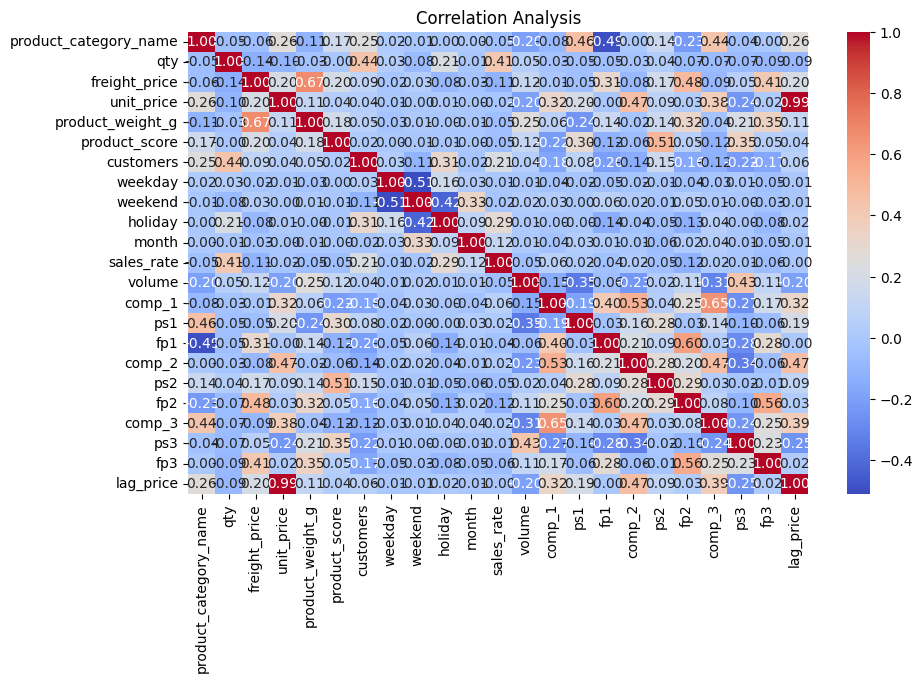

In [77]:
# correlation analysis
corr = df.corr()
plt.figure(figsize= (10, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Analysis")
plt.show()

In [78]:
# setting feature and target
x = df.drop(columns= ['lag_price'])
y = df['lag_price']
numeric_columns.remove('lag_price')

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_columns),
    ('cat', OneHotEncoder(handle_unknown= 'ignore', sparse_output= False), non_numeric_columns)
])

# split dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state= 42)

# data preprocessing
x_train = preprocessor.fit_transform(x_train)
x_test = preprocessor.fit_transform(x_test)

In [79]:
# model dictionary
model_dict = {
    'linear regression': LinearRegression(),
    'ridge': Ridge(random_state=42, max_iter=1000),
    'lasso': Lasso(random_state=42, max_iter=1000),
    'decision tree': DecisionTreeRegressor(random_state=42),
    'random forest': RandomForestRegressor(random_state=42),
    'gradient boosting': GradientBoostingRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'SVR': SVR(),
    'linear SVR': LinearSVR(random_state=42, max_iter=1000),
    'XGBoost': XGBRegressor(random_state=42, verbosity=0),
    'lightgbm': LGBMRegressor(random_state=42),
    'catboost': CatBoostRegressor(verbose=0, learning_rate=0.0086, random_state=42),
}

# hyperparameter details
search_space = {
    'alpha': [0.1, 1.0, 10.0],
    'max_iter': [1000],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'epsilon': [0.1, 0.5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'num_leaves': [31, 50],
    'boosting_type': ['gbdt', 'dart'],
    'min_child_samples': [10, 20],
    'depth': [4, 6],
    'iterations': [500, 1000],
}
catboost_search_space = {
    'iterations': [1000],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 10],
}

# filter hyperparameter
def filter_hyperparameter(model, space):
    if isinstance(model, CatBoostRegressor):
        return catboost_search_space
    valid_key = model.get_params()
    param_grid = {k:v for k,v in space.items() if k in valid_key}
    return param_grid

In [80]:
# model training with grid search
result = []
i = 0
for name, model in model_dict.items():
    print(f'Tuning for {name}')
    param_grid = filter_hyperparameter(model, search_space)
    scoring = {
        'mae': make_scorer(mean_absolute_error),
        'rmse': make_scorer(root_mean_squared_error),
        'r2': make_scorer(r2_score),
    }
    grid = GridSearchCV(estimator= model, param_grid= param_grid, cv= 5, scoring= scoring, refit= 'r2', n_jobs= -1)
    grid.fit(x_train, y_train)
    best_model = grid.best_estimator_
    y_predict = best_model.predict(x_test)
    result.append({
        'model_name': name,
        'best_parameter': grid.best_params_,
        'mae': round(mean_absolute_error(y_test, y_predict), 4),
        'rmse': round(root_mean_squared_error(y_test, y_predict), 4),
        'r2': round(r2_score(y_test, y_predict), 4),
    })
    i+=1
print('model tuning completed')

Tuning for linear regression
Tuning for ridge
Tuning for lasso
Tuning for decision tree
Tuning for random forest
Tuning for gradient boosting
Tuning for AdaBoost
Tuning for SVR
Tuning for linear SVR
Tuning for XGBoost
Tuning for lightgbm
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 540, number of used features: 30
[LightGBM] [Info] Start training from score 109.144185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

In [81]:
# finding best model
model_df = pd.DataFrame(result)
model_df.sort_values(by= 'r2', ascending= False, inplace= True)
best_model = model_df.iloc[0]['model_name']
best_parameter = model_df.iloc[0]['best_parameter']
print("best model is:", best_model)
print("best parameter is:", best_parameter)
model_df

best model is: catboost
best parameter is: {'depth': 4, 'iterations': 1000, 'l2_leaf_reg': 1}


,model_name,best_parameter,mae,rmse,r2
11,catboost,"{'depth': 4, 'iterations': 1000, 'l2_leaf_reg'...",8.8873,11.0121,0.9786
9,XGBoost,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",8.8293,11.3973,0.9771
4,random forest,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",9.0501,11.3828,0.9771
8,linear SVR,"{'C': 10, 'epsilon': 0.5, 'max_iter': 1000}",9.6793,11.3900,0.9771
7,SVR,"{'C': 1, 'epsilon': 0.1, 'kernel': 'linear', '...",9.7113,11.4351,0.9769
0,linear regression,{},9.6121,11.6468,0.9760
1,ridge,"{'alpha': 0.1, 'max_iter': 1000}",9.6209,11.6468,0.9760
5,gradient boosting,"{'alpha': 0.1, 'learning_rate': 0.05, 'max_dep...",9.4710,11.8254,0.9753
2,lasso,"{'alpha': 0.1, 'max_iter': 1000}",10.2574,11.9805,0.9746
6,AdaBoost,"{'learning_rate': 0.1, 'n_estimators': 200}",10.1972,13.0564,0.9699


[Text(0, 0, 'catboost'),
 Text(1, 0, 'XGBoost'),
 Text(2, 0, 'random forest'),
 Text(3, 0, 'linear SVR'),
 Text(4, 0, 'SVR'),
 Text(5, 0, 'linear regression'),
 Text(6, 0, 'ridge'),
 Text(7, 0, 'gradient boosting'),
 Text(8, 0, 'lasso'),
 Text(9, 0, 'AdaBoost'),
 Text(10, 0, 'decision tree'),
 Text(11, 0, 'lightgbm')]

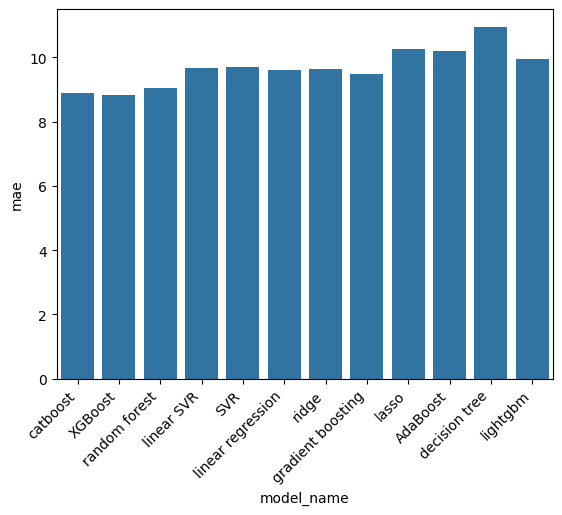

In [82]:
# visualize mean absolute error
ax = sns.barplot(x='model_name', y='mae', data=model_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

[Text(0, 0, 'catboost'),
 Text(1, 0, 'XGBoost'),
 Text(2, 0, 'random forest'),
 Text(3, 0, 'linear SVR'),
 Text(4, 0, 'SVR'),
 Text(5, 0, 'linear regression'),
 Text(6, 0, 'ridge'),
 Text(7, 0, 'gradient boosting'),
 Text(8, 0, 'lasso'),
 Text(9, 0, 'AdaBoost'),
 Text(10, 0, 'decision tree'),
 Text(11, 0, 'lightgbm')]

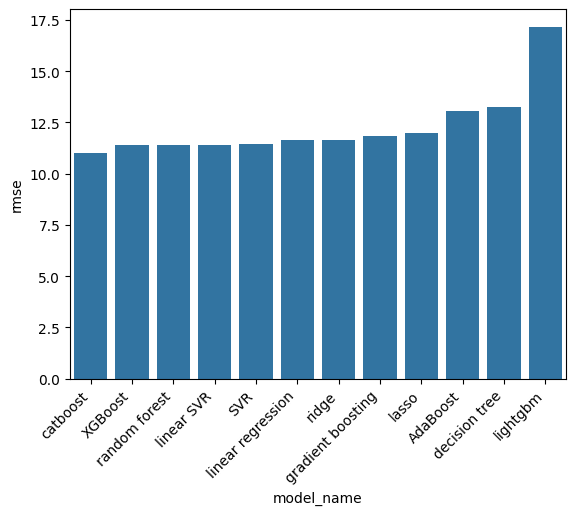

In [83]:
# visualize root mean square error
ax = sns.barplot(x='model_name', y='rmse', data=model_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

[Text(0, 0, 'catboost'),
 Text(1, 0, 'XGBoost'),
 Text(2, 0, 'random forest'),
 Text(3, 0, 'linear SVR'),
 Text(4, 0, 'SVR'),
 Text(5, 0, 'linear regression'),
 Text(6, 0, 'ridge'),
 Text(7, 0, 'gradient boosting'),
 Text(8, 0, 'lasso'),
 Text(9, 0, 'AdaBoost'),
 Text(10, 0, 'decision tree'),
 Text(11, 0, 'lightgbm')]

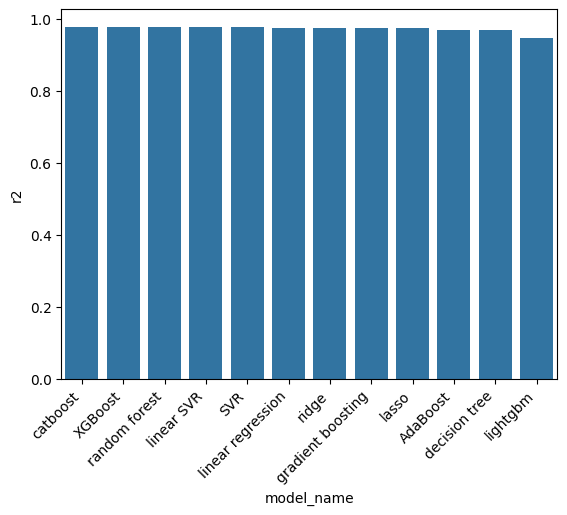

In [84]:
# visualize r2 score
ax = sns.barplot(x='model_name', y='r2', data=model_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

In [85]:
# final model
final_model = model_dict[best_model].set_params(**best_parameter)

# final training and testing
final_model.fit(x_train, y_train)
y_predict = final_model.predict(x_test)

# model evaluation
mae = mean_absolute_error(y_test, y_predict)
rmse = root_mean_squared_error(y_test, y_predict)
r2 = r2_score(y_test, y_predict)

print('best model: ',best_model)
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Absolute Error: {rmse}')
print(f'R2 score: {r2}')

best model:  catboost
Mean Absolute Error: 8.887258458025372
Root Mean Absolute Error: 11.012054795145996
R2 score: 0.978578032144269


In [86]:
# retrain model
x = preprocessor.fit_transform(x)
final_model.fit(x, y)

# pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', final_model)
])

# save model
model_name = "model.pkl"
with open(model_name, 'wb') as f:
    cloudpickle.dump(pipeline, f)
print(f'model saved as {model_name}')

model saved as model.pkl


In [87]:
# save everything
save_session()

Session saved to variables.session
